# Data Importing

In [1]:
import pandas as pd
from joblib import load

file = load('data_clean.z')
train_ts = file['train']
val_ts = file['val']
test_ts = file['test']

# Custom GridSearch Creation
Create a gridearch module for SARIMA models


## Accuracy Metric
Define an accuracy metric (e.g. MAPE)

In [2]:
import numpy as np

def mape(y, yhat):
    """Mean Absolute Percent Error
    
    Parameters:
    -----------
    y: Numpy array
        The actual values
        
    yhat: Numpy array
        The predicted values for comparison with actuals
        
    Returns:
    --------
        Float
    """
    return np.mean(abs((yhat - y)/y))

## Test Function
Define a function that takes in a SARIMAX model, an accuracy metric, its parameters, train and test series, then output the test results

In [3]:
def train_forecast(train_series, test_series, model, err_fn, 
                   kwargs, fkwargs, mkwargs, tkwargs):
    try:
        model_fit = model(train_series, **kwargs, **mkwargs).fit(**fkwargs)
        yhat = model_fit.forecast(len(test_series), **tkwargs)
        return (str(kwargs), {'accuracy': err_fn(test_series.values, yhat), 
                'aic': model_fit.aic, 'bic': model_fit.bic})
    except:
        return (str(kwargs), {'accuracy': np.nan, 
                'aic': np.nan, 'bic': np.nan})

## Parameter Wrapper
Define a function that takes in a a dictionary of parameters *'Params'* and their corresponding list of values to search, then creates an output in the format *'Params_wrapper'* needed for SARIMA models

In [4]:
def wrap_params(Params, Params_wrapper):
    wrapped = Params_wrapper.copy()
    for key in Params_wrapper.keys():
        typ = type(Params_wrapper[key])
        if typ == str or typ == type(None):
            wrapped[key] = Params[Params_wrapper[key]]
        else:
            wrapped[key] = typ(Params[x] for x in Params_wrapper[key])
    return wrapped

## GridSearch Class
Create a class object for hyperparameter tuning. The object should be initialized with the model, a parameter grid, and the accuracy metric. The methods of the class should include:
* **fit:** trains and scores the model for each value in the parameter grid
* **best_param:** returns the top winning parameter combinations
* **best_score:** returns the score for the top winning parameter combination

In [5]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
from itertools import product
import warnings

# Gridsearch class object for statsmodels SARIMAX
class GridSearch(object):
    """hyper-parameter optimization via grid-search for time-series models
    
    Parameters:
    -----------
    model: model object
        prediction model with fit and predict methods
        
    Params: Dictionary
        dictionary of model parameters and list of ranges to apply gridsearch
        
    Params_wrapper: Dictionary (optional)
        If given, then the parameters in Params need to be entered using the
        format defined in Params_wrapper
        
    test_method: String
        The prediction method used by model. Some models predict using a
        'predict' method while other use a 'forecast' method.
        
    n_jobs: Integer, default -1
        Number of workers to divide the process on (parallelization)
        
    err_fn: Object
        Error function to use for model evaluation. The following strings can 
        All error functions must take at least 2 inputs (actuals and predictions)
    
    fkwargs: Dictionary
            Optional Parameters to pass to 'fit' method
        
    Attributes:
    -----------
    """
    def __init__(self, model, Params, Params_wrapper=None, n_jobs=-1, err_fn=None, fkwargs={}):
        self.model = model
        self.Params_wrapper = Params_wrapper
        self.n_jobs = n_jobs
        
        # unwrap parameters
        self.Params = list(dict(zip(Params, x)) for x in product(*Params.values()))
        
        # error function
        self.err_fn = err_fn
            
        # optional fitting kwargs
        self.fkwargs = fkwargs
        
    def fit(self, train_series, test_series, mkwargs={}, tkwargs={}):
        """
        
        Parameters:
        -----------
        train_series: Pandas Series
            training samples
        
        test_series: Pandas Series
            Out-of-sample (i.e. future) set of prediction samples
            
        mkwargs: Dictionary
            Optional variables to pass to the model function (e.g. exog variables)
            
        tkwargs: Dictionary
            Optional variables to pass to the test function (e.g. exog variables)
        
        Return:
        -------
            Instant of self
        """
        #Wrap Parameters if needed
        warnings.filterwarnings("ignore")
        if self.Params_wrapper:
            self.Params = (wrap_params(Params, self.Params_wrapper) for Params in self.Params)
            self.Params = list(self.Params)
        
        # Parralelize evaluation
        self.output = Parallel(n_jobs=self.n_jobs)(delayed(train_forecast)(
                train_series, test_series, self.model, self.err_fn, 
                kwargs, self.fkwargs, mkwargs, tkwargs) for kwargs in self.Params)
        self.output = dict(self.output)
        self.output = pd.DataFrame(self.output).T
        self.output.sort_values('accuracy', inplace=True)
        
        return self
        
    def best_param(self, top=1):
        """Model Parameters Yielding Best Accuracy
        
        Parameters:
        -----------
        top: Integer, default 1
            Number of parameters to select from top of the list
        
        Returns:
        --------
            List
        """
        return self.output.index[0:top]
    
        
    def best_score(self, top=1):
        """Top Accuracy Measures Obtained Corresponding to best_param
        
        Parameters:
        -----------
        top: Integer, default 1
            Number of scores to select from top of the list
        
        Returns:
        --------
            numpy array
        """
        return self.output.values[0:top]

# Hyperparameter Tuning

## GridSearch
Using the created gridsearch class for SARIMA models and the MAPE function, tune the model by exploring the combinations of following different SARIMA parameters:
* **AR** ranges 0 to 3
* **I** range 0 to 1
* **MA** ranges 0 to 3
* **SAR** ranges 0 to 3
* **SI** ranges 0 to 1
* **SMA** ranges 0 to 3
* **S** as 24

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import time

model = SARIMAX
Params = {'p': list(np.arange(0, 4)),
          'd': [0, 1],
          'q': list(np.arange(0, 4)),
          'P': list(np.arange(0, 4)),
          'D': [0, 1],
          'Q': list(np.arange(0, 4)),
          'S': [24]}
Params_wrapper = {'order': ('p', 'd', 'q'), 'seasonal_order': ('P', 'D', 'Q', 'S')}
gs = GridSearch(model, Params, Params_wrapper=Params_wrapper, n_jobs=-1, err_fn=mape, 
               fkwargs={'method':'nm', 'disp':False})
combinations = len(gs.Params)
print('This will try out {} combinations of model parameters'.format(len(gs.Params)))

This will try out 1024 combinations of model parameters


In [7]:
# Apply grid search (best run this on a machine with multiple cores for speed)
start = time.time() # record start time
gs.fit(train_ts, val_ts)
print('{0} models tested in {1} minutes'.format(combinations, (time.time()-start)/60))

1024 models tested in 17.198094395796456 minutes


## Selection & in-sample Training
Inspect the top 5 models and use the best one to train the full, within sample, data (i.e. train+val)

In [11]:
gs.output.head()

,accuracy,aic,bic
"{'order': (1, 0, 0), 'seasonal_order': (0, 1, 3, 24)}",0.137611,-6104.469639,-6079.758855
"{'order': (3, 0, 0), 'seasonal_order': (0, 1, 3, 24)}",0.138571,-6129.730951,-6095.135854
"{'order': (2, 0, 0), 'seasonal_order': (0, 1, 3, 24)}",0.139729,-6123.975556,-6094.322615
"{'order': (3, 0, 0), 'seasonal_order': (0, 1, 2, 24)}",0.140001,-6137.131808,-6107.478868
"{'order': (2, 0, 1), 'seasonal_order': (0, 1, 3, 24)}",0.140437,-6148.811409,-6114.216312


In [15]:
is_ts = train_ts.append(val_ts)

model = SARIMAX(is_ts, order=(1, 0, 0), seasonal_order=(0, 1, 3, 24))
start = time.time()
model_fit = model.fit(dis=0)
print('fitting complete after {} seconds'.format(time.time()-start))

fitting complete after 94.88529920578003 seconds


# Forecasting
Generate forecast for the future and convert forecasts to pandas format for easier inspection and plotting

In [16]:
f_steps = test_ts.shape[0]
results = model_fit.get_forecast(f_steps)

forecasts = pd.concat([results.predicted_mean, results.conf_int(alpha=0.05)], axis=1) 
forecasts.columns = ['Forecasts', 'Lower 95% CI', 'Upper 95% CI']

forecasts.head()

,Forecasts,Lower 95% CI,Upper 95% CI
2011-08-23 14:00:00,0.125252,0.100648,0.149857
2011-08-23 15:00:00,0.135048,0.105400,0.164696
2011-08-23 16:00:00,0.121904,0.090240,0.153568
2011-08-23 17:00:00,0.109568,0.077033,0.142103
2011-08-23 18:00:00,0.107122,0.074202,0.140043


# Evaluation
Compare forecasts against the out-of-sample test set

Text(0.5, 1.0, 'MSE: 0.0004415588299343799')

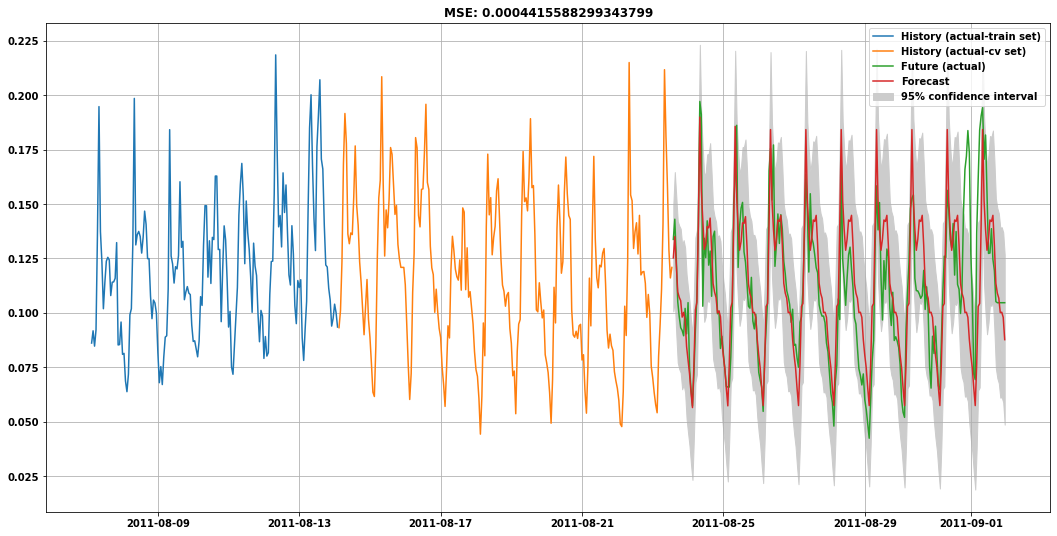

In [18]:
import matplotlib.pyplot as plt

mse = ((test_ts.values - results.predicted_mean)**2).mean()

plt.figure(figsize=(18,9))
plt.plot(train_ts[-24*7:], label='History (actual-train set)')
plt.plot(val_ts, label='History (actual-cv set)')
plt.plot(test_ts, label='Future (actual)')
plt.plot(forecasts['Forecasts'], label='Forecast')
plt.fill_between(forecasts.index, forecasts['Lower 95% CI'], forecasts['Upper 95% CI'], color='0.8',label='95% confidence interval')
plt.legend()
plt.grid()
plt.title('MSE: '+ str(mse))

Compare this with the initial results before hypyerparameter tuning. Notice how the confidence intervals became narrower and the MSE improved from 0.0016 to 0.00044!